#**Машинное обучение ИБ-2024**

#**Домашнее задание 3.**
#Классификация текстов, методы обучения без учителя.

**Все выводы ячеек вашей сданной работы должны оставаться в сданном ноутбуке, результаты должны быть видны. В противном случае 0 за задание!**

## Классификация текстов.

В этой части домашней работы Вам требуется реализовать полный пайплайн работы с текстами и моделями машинного обучения. От предобработки до запуска обучения моделей для задачи классификации.

**Задачи**:
1. Предобработка - Вам необходимо в представленных текстах избавиться от пунктуации, чисел и стоп-слов (nltk stopwords), привести тексты к нижнему регистру.
2. Сделать на Вашем корпусе очищенных текстов Лемматизацию или Стемминг. При этом словестно пояснить, что делает метод.
3. Разбить полученный датасет на train и test выборки в отношении 4:1
4. Привести ваши тексты из датасета к векторному формату. Тут необходимо попробовать два метода, разобранных на семинаре: Bag of words и TF-IDF. При этом словестно пояснить, что делает метод.
5. Провести кросс-валидация на подбор гиперпараметров моделей (GridSearchCV) и обучить модели: Логистическая регрессия, Random Forest, Gradient Boosting из CatBoost или XGBoost или LightGBM. (В данном задании не стоит "упарываться" в подбор гиперпараметров и считать каждую модель по 10 часов, покажите в коде, что Вы перебирали по сетке 2-3 гиперпараметра в разумном по времени интервале).
6. Замерьте метрики accuracy, precision, recall, F1-Score, ROC-AUC. Постройте ConfusionMatrix, сделайте анализ решения.

Все пункты задания весят по 1 Баллу. То есть за данный раздел можно получить максимум 6 Баллов.

1) Загрузим и обрежем датасет до 25000

In [ ]:
import numpy as np
import pandas as pd
import sklearn
import nltk
import matplotlib.pyplot as plt
from IPython.display import clear_output

nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
df = pd.read_csv('combined_data.csv')
df = df.iloc[:25000]
stop_words = set(stopwords.words('english'))

def delete_stop_words(text: str):
  words = text.split(' ')
  clean_words = [w.lower() for w in words if w.isalpha() and (w.lower() not in stop_words)]
  return clean_words

df['text'] = df['text'].apply(delete_stop_words)
df.sample(5)

,label,text
17731,1,"[spring, sprung, warmer, weather, comming, tim..."
14746,1,"[know, face]"
12935,1,"[dear, valued, member, letter, united, medical..."
9501,0,"[author, metze, date, escapenumber, escapenumb..."
24138,0,"[spay, nueter, assistance, program, n, p, seek..."


2) Лематизация - возвращение слов к исходной форме (падежу, числу и тд для русского языка)\
Стемминг - обрезка части слова, сохраняя смысловую основу слова

In [ ]:
lemm = WordNetLemmatizer()
def lemmatization(text):
  return ' '.join([lemm.lemmatize(i) for i in text])
df['text'] = df['text'].apply(lemmatization)

3) Реализуем с помощь утилиты из sklearn

In [ ]:
from sklearn.model_selection import train_test_split

X = df['text']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle= True)

4) Bag_of_words - сумма onehot векторов слов одного предложения\
Tf-Idf - мера "важности" слова в контексте, опирается на частоту слова в документе и штраф за большую частоту во всем блоке документов\
Предлагается использовать TfIdf поскольку данный метод хранит в себе больше информации о тексте

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(encoding = "utf-8")
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

5) Создадим общую функцию обучения и протестируем все модельки

In [ ]:
from sklearn.model_selection import GridSearchCV

def grid_searching(estimator, parameters):
  model = GridSearchCV(estimator, parameters,scoring='accuracy', cv=5, n_jobs= -1)
  model.fit(X_train, y_train)
  return model.best_estimator_

In [ ]:
from sklearn.linear_model import LogisticRegression
parlogreg = {
    'C': np.logspace(-1,1,3),
    'penalty' : ['l2', None],
    'solver' : ['sag', 'lbfgs']
}
logregr = grid_searching(LogisticRegression(),parlogreg )

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [ ]:
from sklearn.ensemble import RandomForestClassifier
parrandforest = {
    'max_depth' : [40, 20],
    'criterion': ['gini', 'entropy']
}
rand_forest = grid_searching(RandomForestClassifier(100), parrandforest)

* Скорее всего катбуст плохо себя покажет, поскольку ему нужно чуть большая глубина и чуть большее количество деревьев

In [ ]:
!pip install catboost
clear_output()

from catboost import CatBoostClassifier
par_catboost = {
    'depth': [3, 5]
}
cat_boost = grid_searching(CatBoostClassifier(100), par_catboost)
clear_output()

6) Для полученных моделе выведем метрики и CM

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import seaborn as sns

def otrisovka(model):
  metriki = { 'accuracy':accuracy_score,
             'precision':precision_score,
              'recall' : recall_score,
              'f1' : f1_score,
              'roc-auc':roc_auc_score}
  for mera in metriki.keys():
    print(mera, metriki[mera](y_test, model.predict(X_test)))

  matr = confusion_matrix(y_test, model.predict(X_test))

  plt.figure(figsize=(8, 6))
  sns.heatmap(matr, annot=True, fmt='d', cmap='magma', xticklabels=['1', '0'], yticklabels=['1', '0'])
  plt.title('Confusion Matrix')
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.show()

accuracy 0.9824
precision 0.9786676646706587
recall 0.9882842025699169
f1 0.9834524257239564
roc-auc 0.9820350494582806


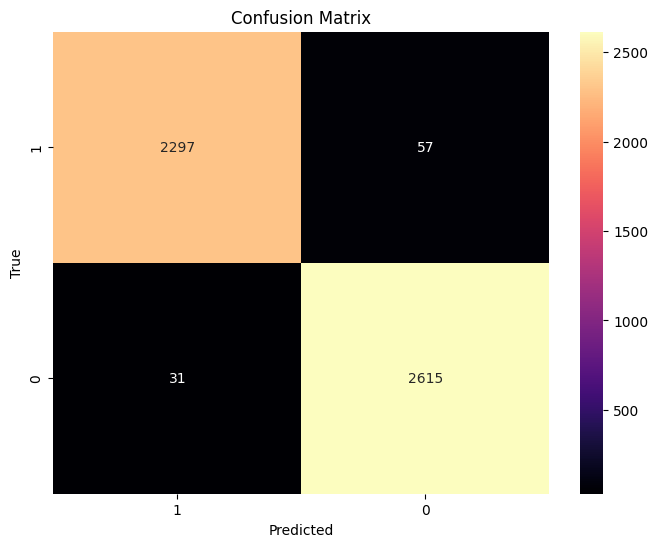

In [ ]:
otrisovka(logregr)

accuracy 0.937
precision 0.902868994123747
recall 0.9871504157218443
f1 0.9431305289763495
roc-auc 0.9338895663995798


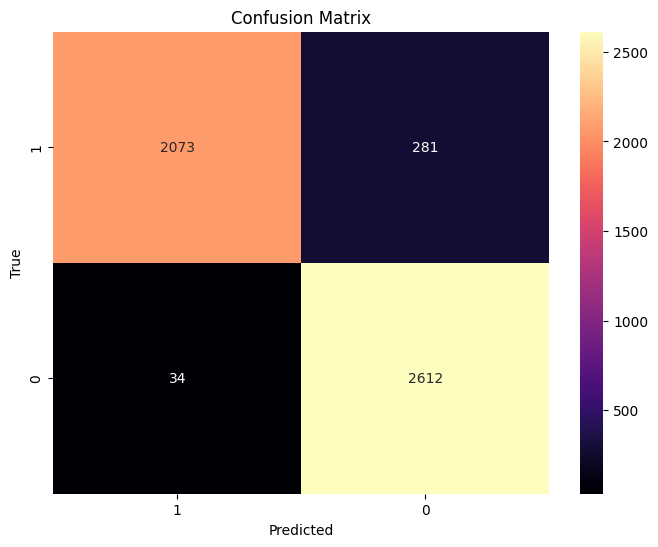

In [ ]:
otrisovka(rand_forest)

accuracy 0.9638
precision 0.9460731089395584
recall 0.9879062736205594
f1 0.9665372527269366
roc-auc 0.9623048785265074


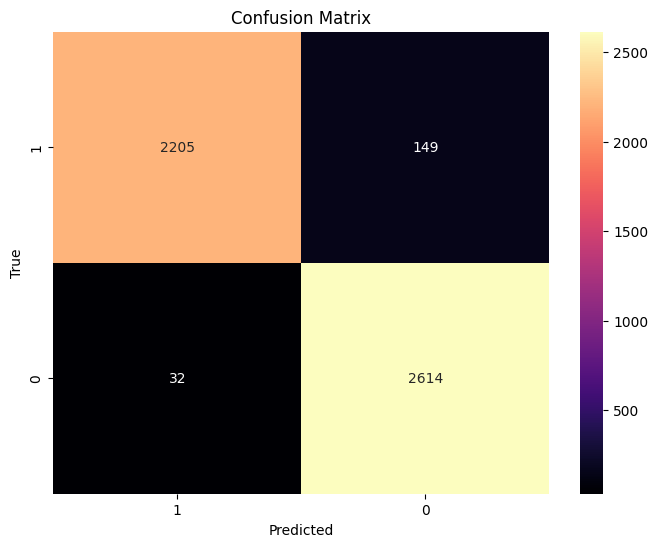

In [ ]:
otrisovka(cat_boost)

## Обучение без учителя

Сгенерируем смесь Гауссовских распределений. Эти данные Вам необходимо будет далее кластеризировать с помощью различных алгоритмов  кластеризации. Во всех заданиях Вам необходимо отрисовывать кластеры, которые Вы получили в результате работы моделей (графики, оси должны быть подписаны).

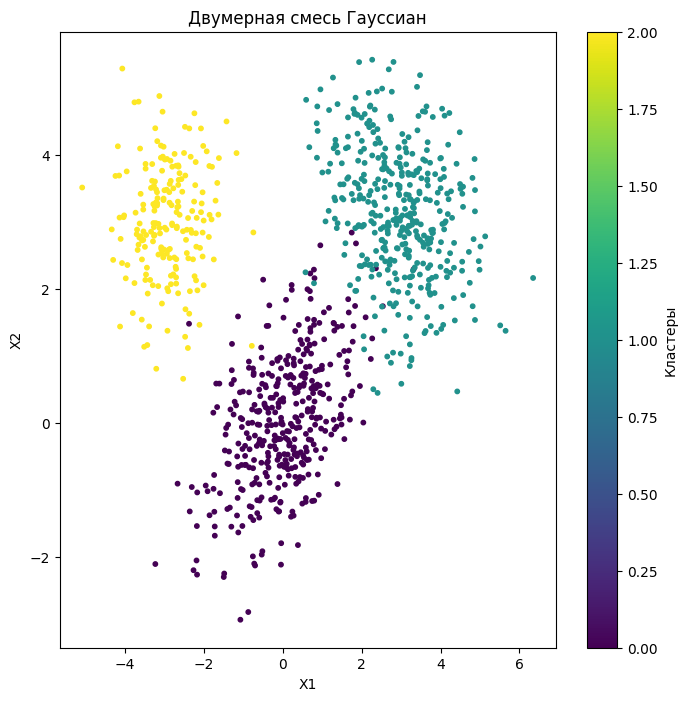

In [ ]:
np.random.seed(42)
n_samples = 1000
means = [[0, 0], [3, 3], [-3, 3]]
covariances = [[[1, 0.5], [0.5, 1]], [[1, -0.4], [-0.4, 1]], [[0.5, 0], [0, 0.75]]]
weights = [0.4, 0.4, 0.2]

X = np.zeros((n_samples, 2))
labels = np.zeros(n_samples, dtype=int)
current = 0

for i, (mean, cov, weight) in enumerate(zip(means, covariances, weights)):
    n_cluster_samples = int(n_samples * weight)
    X[current : current + n_cluster_samples, :] = np.random.multivariate_normal(mean, cov, n_cluster_samples)
    labels[current : current + n_cluster_samples] = i
    current += n_cluster_samples

plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=10)
plt.title("Двумерная смесь Гауссиан")
plt.xlabel("X1")
plt.ylabel("X2")
plt.colorbar(label="Кластеры")
plt.show()

**Задание 1 [1 Балл].** Заиспользуйте метод K-Means для кластеризации полученной смесси Гауссовских распределений. Подберите гиперпараметр K максимизируя метрику индекс Силуэта (Silhouette Coefficient).

**Задание 2 [1 Балл].** Заиспользуйте метод DBSCAN для кластеризации полученной смесси Гауссовских распределений. Подберите гиперпараметры eps, min_samples максимизируя метрику BCubed (золотой стандарт записан в переменной labels).

**Задание 3 [2 Балл].** Реализуйте EM алгоритм для кластеризации смеси Гауссовских смесей. Попробуйте его применить для кластеризации. Распишите, что делает E и M шаги в коде комментариями. Напишите краткий отчет, какой из алгоритмов кластеризации сработал лучше всего на сгенерированных данных.

EM алгоритм для разделения смеси Гауссовских распределений:

$$
p(X, Z|\pi, \mu, \Sigma) = \prod_{i=1}^\ell \prod_{k=1}^K \Big[\pi_k \mathcal{N}(x_i | \mu_k, \Sigma_k) \Big]^{z_ik}
$$

Соответственно, Е-шаг:

$$
g_{ik} := p\big(z_{ik} = 1\big|x_i, \pi, \mu, \Sigma\big) = \frac{\pi_k \mathcal{N}(x_i | \mu_k, \Sigma_k)}{\sum_{s=1}^K \pi_s \mathcal{N}(x_i | \mu_s, \Sigma_s)}
$$

И М-шаг:

$$
\pi_k = \frac{1}{\ell} \sum_{i=1}^\ell g_{ik} \quad\quad \mu_k = \frac{1}{\ell \pi_k} \sum_{i=1}^\ell g_{ik} x_i
$$

$$
\Sigma_k = \frac{1}{\ell \pi_k} \sum_{i=1}^\ell g_{ik} (x_i - \mu_k) (x_i - \mu_k)^T
$$

**Бонус [1 Балл].** Заиспользуйте модель GaussianMixture для кластеризации сгенерированной выборки. Мы не проходили GaussianMixture, поэтому для бонусного балла ознакомьтесь с моделью и опишите, как она работает.